## Les librairies


In [1]:

import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import regularizers
from PIL import Image
from keras.utils import to_categorical
import cv2
import numpy as np
import joblib

In [2]:
#pip install livelossplot

## Les fonctions

In [4]:
## Prétraitement de l'image : redimensionnemennt et standardization
def preprocess_img(img,new_dim=(240,320)):
    new_img=cv2.resize(img, (new_dim[1],new_dim[0]), interpolation = cv2.INTER_AREA)
    mean = np.mean(new_img)
    std = np.std(new_img)
    new_img=(new_img-mean)/std
    return new_img

## Récupération des images et préparation de la dataset

In [7]:


# Chemin vers le dossier principal contenant les sous-dossiers
main_folder = '/home/diaby/IA_EXOS/CAS_PRATIQUES/MMU-Iris-Database'
img_dim=(240,320,3)


In [ ]:
X_left=[]
Y_left=[]


for target_folder in os.listdir(main_folder):
    target_path = os.path.join(main_folder, target_folder)

    if os.path.isdir(target_path):
        for side in ['left']:#, 'right']:
            side_path = os.path.join(target_path, side)
            if os.path.isdir(side_path):
                for image_filename in os.listdir(side_path):
                    if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
                        image_path = os.path.join(side_path, image_filename)
                        target =int(target_folder)
                        image = preprocess_img(cv2.imread(image_path),img_dim)
                        X_left.append(image)
                        Y_left.append(target)

In [ ]:
pd.Series(Y_left).value_counts()

17    10
10     8
26     8
39     8
11     7
1      5
41     5
35     5
32     5
29     5
43     5
40     5
42     5
44     5
38     5
45     5
28     5
37     5
46     5
7      5
9      5
6      5
5      5
34     5
3      5
36     5
33     5
15     5
16     5
14     5
12     5
13     5
24     5
2      5
23     5
22     5
20     5
21     5
25     5
19     5
27     5
31     5
30     5
18     5
8      5
dtype: int64

In [ ]:
# Encodage des étiquettes pour l'œil gauche
from sklearn import preprocessing
labelEnc_left = preprocessing.LabelEncoder()
Y_left_enc = labelEnc_left.fit_transform(Y_left)


joblib.dump(labelEnc_left,'/home/diaby/IA_EXOS/CAS_PRATIQUES/labelEnc_left.joblib')

['/content/drive/MyDrive/Authentification Employés/CAS_PRATIQUES/CAS_PRATIQUES/labelEnc_left.joblib']

In [ ]:
# Divisez les données en ensembles d'entraînement, de validation et de test pour l'œil gauche

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Diviser les données en ensembles d'entraînement, de validation et de test
X_left_train, X_left_temp, y_left_train, y_left_temp = train_test_split(X_left, Y_left_enc, test_size=0.4, random_state=42, stratify=Y_left_enc)
X_left_val, X_left_test, y_left_val, y_left_test = train_test_split(X_left_temp, y_left_temp, test_size=0.5, random_state=42, stratify=y_left_temp)

# Convertir les étiquettes en catégories
y_left_train_enc = to_categorical(y_left_train)
y_left_val_enc = to_categorical(y_left_val)
y_left_test_enc = to_categorical(y_left_test)

In [ ]:
# Vérifier la taille de X_left_train
taille_X_left_train = len(X_left_train)
print("Taille de X_left_train :", taille_X_left_train)

# Vérifier la taille de y_left_train_enc
taille_y_left_train_enc = len(y_left_train_enc)
print("Taille de y_left_train_enc :", taille_y_left_train_enc)


Taille de X_left_train : 144
Taille de y_left_train_enc : 144


In [ ]:
pd.Series(y_left_test).value_counts()

24    2
15    2
8     2
37    2
25    1
31    1
16    1
27    1
0     1
4     1
20    1
32    1
36    1
2     1
33    1
1     1
35    1
10    1
43    1
41    1
28    1
13    1
21    1
18    1
29    1
5     1
12    1
6     1
11    1
7     1
44    1
38    1
14    1
42    1
23    1
26    1
19    1
17    1
30    1
40    1
22    1
34    1
9     1
3     1
39    1
dtype: int64

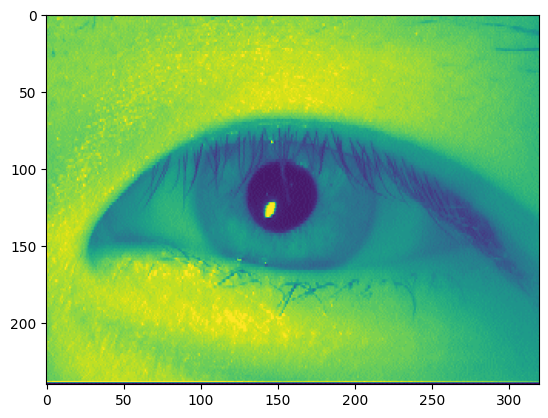

In [ ]:
plt.imshow(X_left_train[0][:,:,2])

## Entrainement du modèle et affichage des performances

In [ ]:
from livelossplot import PlotLossesKeras
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [ ]:
from keras.applications.vgg16 import VGG16

from keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten
NBCLASSES = 45
IMSIZE=[240,320]
def create_model():
    vgg = VGG16(input_shape=IMSIZE + [3], weights='imagenet', include_top=False)

    # Freeze existing VGG already trained weights

    for layer in vgg.layers:
        layer.trainable = False

    # get the VGG output
    out = vgg.output

    # Add new dense layer at the end
    x = Flatten()(out)
    x = Dense(NBCLASSES, activation='softmax')(x)

    model = Model(inputs=vgg.input, outputs=x)

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

    model.summary()

    return model

OG_model = create_model()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 160, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 80, 128)       0   

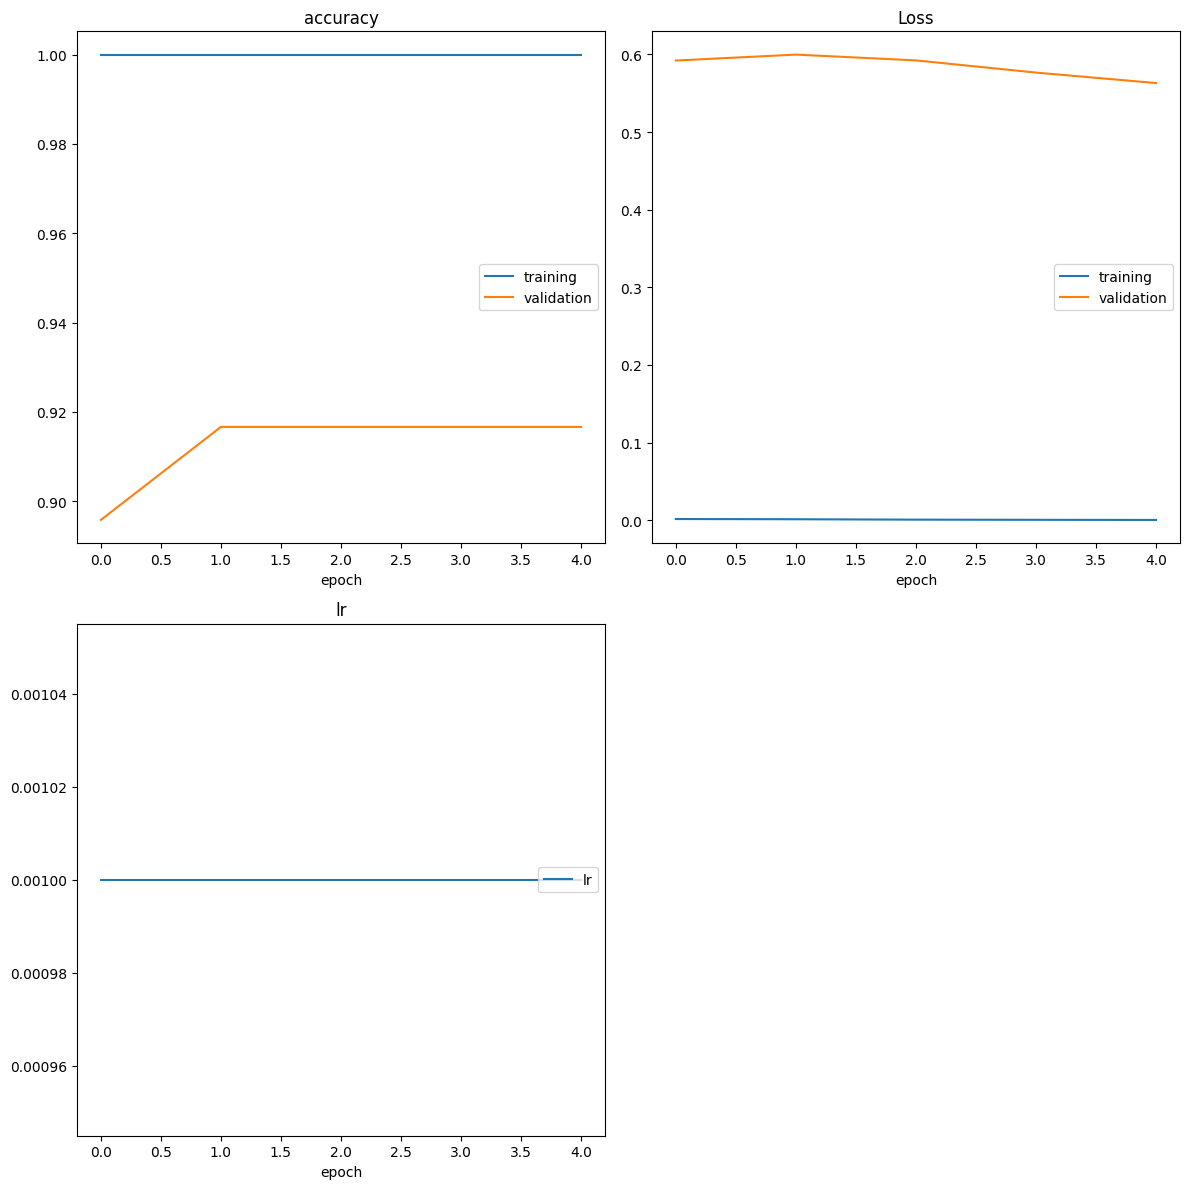

accuracy
	training         	 (min:    1.000, max:    1.000, cur:    1.000)
	validation       	 (min:    0.896, max:    0.917, cur:    0.917)
Loss
	training         	 (min:    0.000, max:    0.002, cur:    0.000)
	validation       	 (min:    0.563, max:    0.600, cur:    0.563)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
5/5 [==============================] - 222s 48s/step - loss: 4.3673e-04 - accuracy: 1.0000 - val_loss: 0.5630 - val_accuracy: 0.9167 - lr: 0.0010


In [ ]:

hist = OG_model.fit(np.array(X_left_train), y_left_train_enc, batch_size = 30, epochs = 5, validation_data=(np.array(X_left_val),y_left_val_enc),callbacks=[rlrop,early,PlotLossesKeras()])

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Exemple de données de test (remplacez cela par vos propres données)

y_left_test_pred = [np.argmax(v) for v in OG_model.predict(np.array(X_left_test))]  # Prédictions du modèle


2/2 [==============================] - 60s 19s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matrice de confusion :
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
Précision : 0.91
Rappel : 0.93
Score F1 : 0.92
Exactitude : 0.94


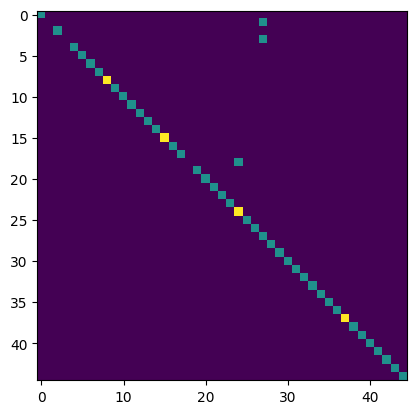

In [ ]:


# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(np.array(y_left_test), np.array(y_left_test_pred))

# # Calcul des mesures de performance
accuracy = accuracy_score(y_left_test, y_left_test_pred)
precision = precision_score(y_left_test, y_left_test_pred,average='macro')
recall = recall_score(y_left_test, y_left_test_pred,average='macro')
f1 = f1_score(y_left_test, y_left_test_pred,average='macro')

print("Matrice de confusion :")
plt.imshow(conf_matrix)
print(conf_matrix)
print("Précision : {:.2f}".format(precision))
print("Rappel : {:.2f}".format(recall))
print("Score F1 : {:.2f}".format(f1))
print("Exactitude : {:.2f}".format(accuracy))

In [ ]:
OG_model.save("vgg16_side_OG2ID_classif")

DATA AUGMENTATION

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

# Créez un générateur de données avec des augmentations pour l'ensemble d'entraînement
datagen_train = ImageDataGenerator(
    rotation_range=10,
    #width_shift_range=0.1,
    zoom_range=(0.95, 1.05),
    brightness_range=(0.95, 1.05),
    fill_mode='nearest'
)

# Créez un générateur de données sans augmentations pour l'ensemble de validation
datagen_val = ImageDataGenerator()



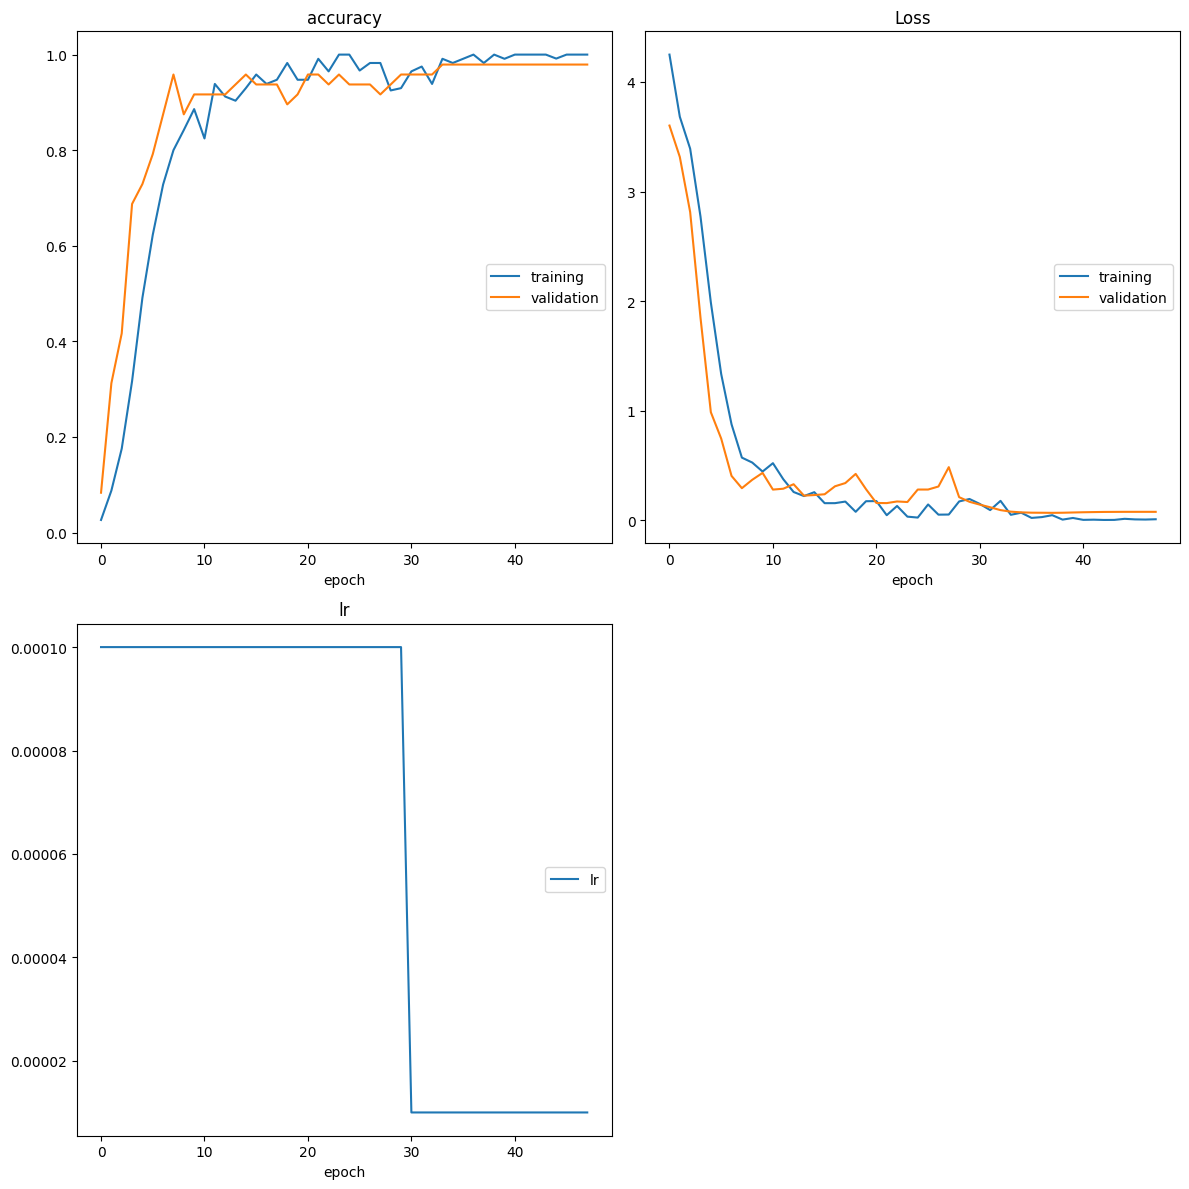

accuracy
	training         	 (min:    0.026, max:    1.000, cur:    1.000)
	validation       	 (min:    0.083, max:    0.979, cur:    0.979)
Loss
	training         	 (min:    0.004, max:    4.249, cur:    0.011)
	validation       	 (min:    0.069, max:    3.602, cur:    0.078)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
4/4 [==============================] - 4s 1s/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.0783 - val_accuracy: 0.9792 - lr: 1.0000e-05


In [ ]:
# Entraînez votre modèle avec les données augmentées

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout
from keras.optimizers import Adam

NBCLASSES = 45
IMSIZE = [240, 320]

def create_improved_model():
    vgg = VGG16(input_shape=IMSIZE + [3], weights='imagenet', include_top=False)

    # Décongelez certaines couches supérieures pour fine-tuning
    for layer in vgg.layers[:15]:
        layer.trainable = True

    # Ajoutez des couches Dropout pour la régularisation
    x = Flatten()(vgg.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(NBCLASSES, activation='softmax')(x)

    model = Model(inputs=vgg.input, outputs=x)

    # Utilisez un taux d'apprentissage adaptatif
    optimizer = Adam(lr=0.0001)

    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=['accuracy'])

    model.summary()

    return model

left_eye_model = create_improved_model()



batch_size = 30  # Vous pouvez ajuster cette valeur en fonction de votre mémoire
epochs = 80

# Callbacks pour ajuster dynamiquement le taux d'apprentissage, arrêter tôt et sauvegarder le meilleur modèle
def lr_schedule(epoch):
    if epoch < 30:
        return 0.0001
    elif epoch < 50:
        return 0.00001
    else:
        return 0.000001

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

# Convertir X_left_train et X_left_val en tableau NumPy
X_left_train_np = np.array(X_left_train)
X_left_val_np = np.array(X_left_val)

# Créez un générateur de lot pour les données d'entraînement avec des augmentations
train_generator = datagen_train.flow(X_left_train_np, y_left_train_enc, batch_size=batch_size, shuffle=True)

# Créez un générateur de lot pour les données de validation (utilisez le même batch_size)
validation_generator = datagen_val.flow(X_left_val_np, y_left_val_enc, batch_size=batch_size, shuffle=False)


# Entraînez le modèle avec les générateurs de lots
history = left_eye_model.fit(
    train_generator,
    steps_per_epoch=len(X_left_train_np) // batch_size,
    epochs=epochs,
    validation_data=validation_generator,  # Utilisez le générateur de validation ici
    callbacks=[lr_scheduler, early_stopping, model_checkpoint, PlotLossesKeras()]
)





In [ ]:
left_eye_model.save('/home/diaby/IA_EXOS/CAS_PRATIQUES/left_eye_model.h5')

2/2 [==============================] - 11s 4s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matrice de confusion :
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
Précision : 0.93
Rappel : 0.96
Score F1 : 0.94
Exactitude : 0.96


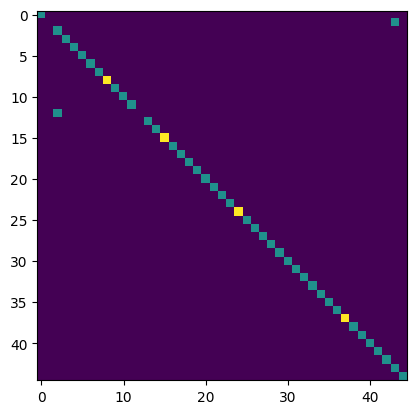

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_left_test_pred = [np.argmax(v) for v in left_eye_model.predict(np.array(X_left_test))]  # Prédictions du modèle


# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(np.array(y_left_test), np.array(y_left_test_pred))

# # Calcul des mesures de performance
accuracy = accuracy_score(y_left_test, y_left_test_pred)
precision = precision_score(y_left_test, y_left_test_pred,average='macro')
recall = recall_score(y_left_test, y_left_test_pred,average='macro')
f1 = f1_score(y_left_test, y_left_test_pred,average='macro')

print("Matrice de confusion :")
plt.imshow(conf_matrix)
print(conf_matrix)
print("Précision : {:.2f}".format(precision))
print("Rappel : {:.2f}".format(recall))
print("Score F1 : {:.2f}".format(f1))
print("Exactitude : {:.2f}".format(accuracy))

Oeil Droit

In [ ]:
# Récupération des données


X_right=[]
Y_right=[]


for target_folder in os.listdir(main_folder):
    target_path = os.path.join(main_folder, target_folder)

    if os.path.isdir(target_path):
        for side in ['right']:#, 'left']:
            side_path = os.path.join(target_path, side)
            if os.path.isdir(side_path):
                for image_filename in os.listdir(side_path):
                    if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
                        image_path = os.path.join(side_path, image_filename)
                        target =int(target_folder)
                        image = preprocess_img(cv2.imread(image_path),img_dim)
                        X_right.append(image)
                        Y_right.append(target)



In [ ]:
pd.Series(Y_right).value_counts()

38    15
25    11
16     9
1      8
39     8
10     6
44     5
34     5
35     5
32     5
29     5
43     5
40     5
42     5
45     5
41     5
36     5
37     5
46     5
7      5
9      5
6      5
5      5
28     5
3      5
33     5
18     5
15     5
14     5
17     5
11     5
12     5
13     5
24     5
2      5
23     5
22     5
20     5
21     5
19     5
26     5
27     5
31     5
30     5
8      5
dtype: int64

In [ ]:
# Encodage des étiquettes pour l'œil gauche
from sklearn import preprocessing
labelEnc_right = preprocessing.LabelEncoder()
Y_right_enc = labelEnc_right.fit_transform(Y_right)

joblib.dump(labelEnc_right,'/home/diaby/IA_EXOS/CAS_PRATIQUES/labelEnc_right.joblib')

['/content/drive/MyDrive/Authentification Employés/CAS_PRATIQUES/CAS_PRATIQUES/labelEnc_right.joblib']

In [ ]:
# Divisez les données en ensembles d'entraînement, de validation et de test pour l'œil gauche

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Diviser les données en ensembles d'entraînement, de validation et de test
X_right_train, X_right_temp, y_right_train, y_right_temp = train_test_split(X_right, Y_right_enc, test_size=0.4, random_state=42, stratify=Y_right_enc)
X_right_val, X_right_test, y_right_val, y_right_test = train_test_split(X_right_temp, y_right_temp, test_size=0.5, random_state=42, stratify=y_right_temp)

# Convertir les étiquettes en catégories
y_right_train_enc = to_categorical(y_right_train)
y_right_val_enc = to_categorical(y_right_val)
y_right_test_enc = to_categorical(y_right_test)

In [ ]:
pd.Series(y_right_test).value_counts()

23    3
36    3
14    2
0     2
35    1
22    1
8     1
19    1
5     1
39    1
42    1
31    1
24    1
13    1
4     1
40    1
20    1
32    1
25    1
2     1
41    1
34    1
27    1
18    1
17    1
10    1
44    1
16    1
26    1
38    1
33    1
21    1
3     1
15    1
43    1
6     1
29    1
1     1
7     1
37    1
28    1
30    1
9     1
12    1
11    1
dtype: int64

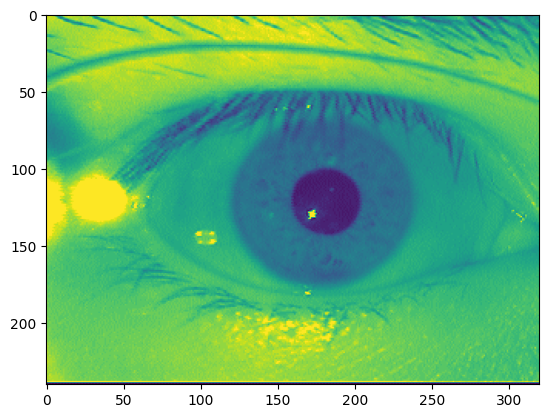

In [ ]:
plt.imshow(X_right_train[0][:,:,2])

Entrainement du Modèle

In [ ]:
from keras.applications.vgg16 import VGG16

from keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten
NBCLASSES = 45
IMSIZE=[240,320]
def create_model():
    vgg = VGG16(input_shape=IMSIZE + [3], weights='imagenet', include_top=False)

    # Freeze existing VGG already trained weights

    for layer in vgg.layers:
        layer.trainable = False

    # get the VGG output
    out = vgg.output

    # Add new dense layer at the end
    x = Flatten()(out)
    x = Dense(NBCLASSES, activation='softmax')(x)

    model = Model(inputs=vgg.input, outputs=x)

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

    model.summary()

    return model

OD_model = create_model()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 160, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 80, 128)       0   

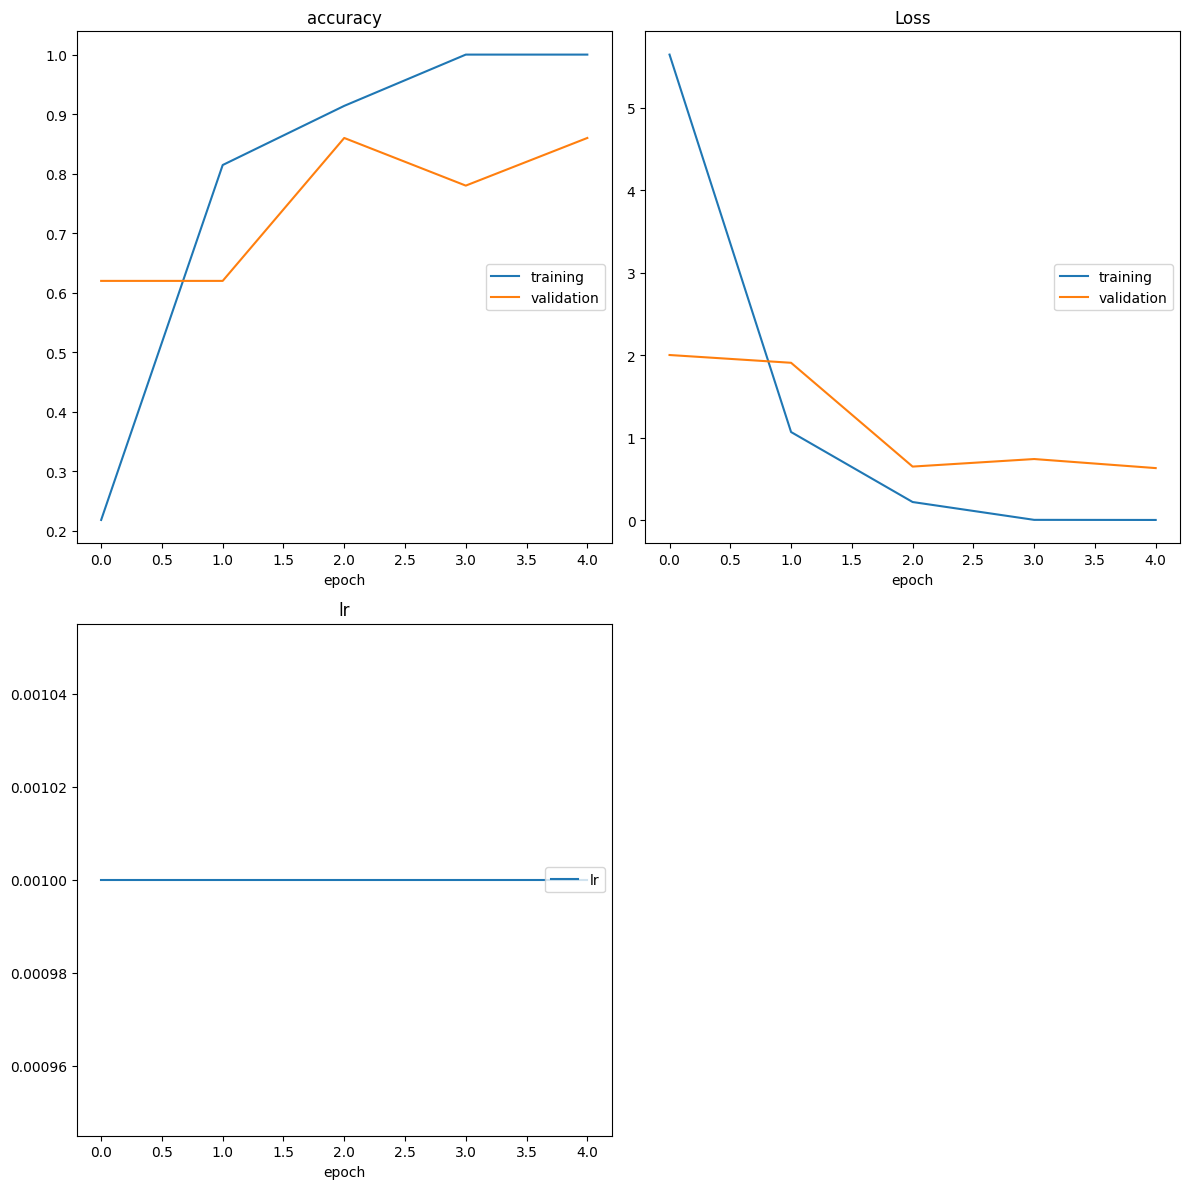

accuracy
	training         	 (min:    0.219, max:    1.000, cur:    1.000)
	validation       	 (min:    0.620, max:    0.860, cur:    0.860)
Loss
	training         	 (min:    0.005, max:    5.644, cur:    0.005)
	validation       	 (min:    0.634, max:    2.004, cur:    0.634)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
6/6 [==============================] - 2s 430ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.6335 - val_accuracy: 0.8600 - lr: 0.0010


In [ ]:

hist = OD_model.fit(np.array(X_right_train), y_right_train_enc, batch_size = 30, epochs = 5, validation_data=(np.array(X_right_val),y_right_val_enc),callbacks=[rlrop,early,PlotLossesKeras()])

Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

# Créez un générateur de données avec des augmentations pour l'ensemble d'entraînement
datagen_train = ImageDataGenerator(
    rotation_range=10,
    zoom_range=(0.95, 1),
    brightness_range=(0.95, 1),
    #width_shift_range=0.1
)

# Créez un générateur de données sans augmentations pour l'ensemble de validation
datagen_val = ImageDataGenerator()



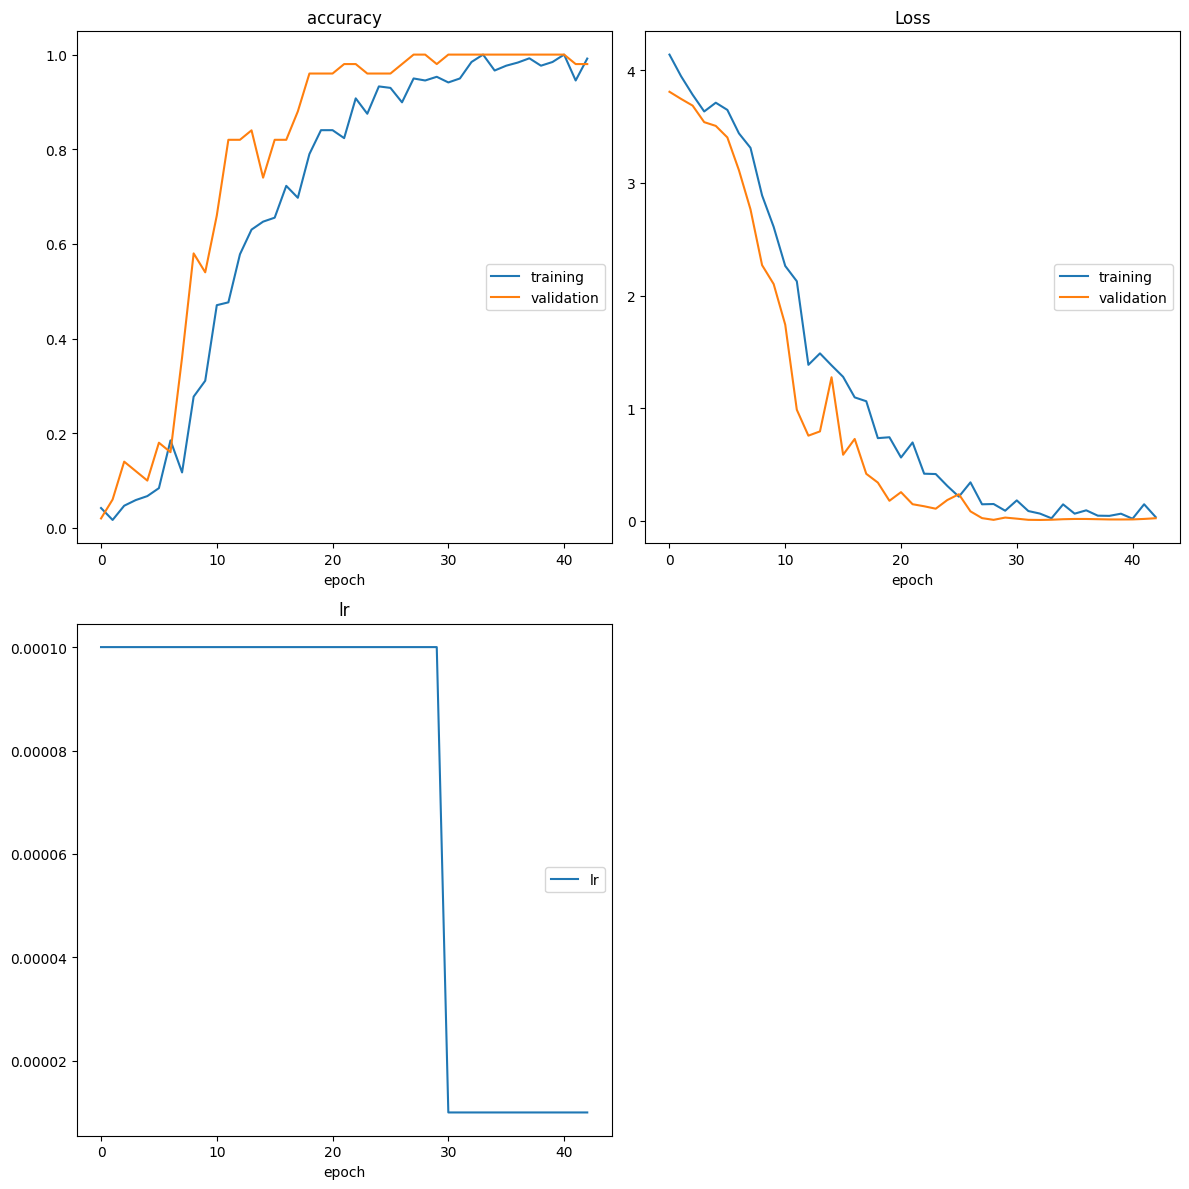

accuracy
	training         	 (min:    0.017, max:    1.000, cur:    0.992)
	validation       	 (min:    0.020, max:    1.000, cur:    0.980)
Loss
	training         	 (min:    0.018, max:    4.140, cur:    0.032)
	validation       	 (min:    0.007, max:    3.810, cur:    0.022)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
4/4 [==============================] - 5s 1s/step - loss: 0.0324 - accuracy: 0.9916 - val_loss: 0.0223 - val_accuracy: 0.9800 - lr: 1.0000e-05


In [ ]:
# Entraînez votre modèle avec les données augmentées

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout
from keras.optimizers import Adam

NBCLASSES = 45
IMSIZE = [240, 320]

def create_improved_model():
    vgg = VGG16(input_shape=IMSIZE + [3], weights='imagenet', include_top=False)

    # Décongelez certaines couches supérieures pour fine-tuning
    for layer in vgg.layers[:15]:
        layer.trainable = True

    # Ajoutez des couches Dropout pour la régularisation
    x = Flatten()(vgg.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(NBCLASSES, activation='softmax')(x)

    model = Model(inputs=vgg.input, outputs=x)

    # Utilisez un taux d'apprentissage adaptatif
    optimizer = Adam(lr=0.0001)

    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=['accuracy'])

    model.summary()

    return model

right_eye_model = create_improved_model()



batch_size = 32  # Vous pouvez ajuster cette valeur en fonction de votre mémoire
epochs = 80

# Callbacks pour ajuster dynamiquement le taux d'apprentissage, arrêter tôt et sauvegarder le meilleur modèle
def lr_schedule(epoch):
    if epoch < 30:
        return 0.0001
    elif epoch < 50:
        return 0.00001
    else:
        return 0.000001

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

# Convertir X_right_train et X_right_val en tableau NumPy
X_right_train_np = np.array(X_right_train)
X_right_val_np = np.array(X_right_val)

# Créez un générateur de lot pour les données d'entraînement avec des augmentations
train_generator = datagen_train.flow(X_right_train_np, y_right_train_enc, batch_size=batch_size, shuffle=True)

# Créez un générateur de lot pour les données de validation (utilisez le même batch_size)
validation_generator = datagen_val.flow(X_right_val_np, y_right_val_enc, batch_size=batch_size, shuffle=False)


# Entraînez le modèle avec les générateurs de lots
history = right_eye_model.fit(
    train_generator,
    steps_per_epoch=len(X_right_train_np) // batch_size,
    epochs=epochs,
    validation_data=validation_generator,  # Utilisez le générateur de validation ici
    callbacks=[lr_scheduler, early_stopping, model_checkpoint, PlotLossesKeras()]
)


In [ ]:
right_eye_model.save('/home/diaby/IA_EXOS/CAS_PRATIQUES/right_eye_model.h5')

2/2 [==============================] - 5s 5s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matrice de confusion :
[[2 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
Précision : 0.97
Rappel : 0.98
Score F1 : 0.97
Exactitude : 0.98


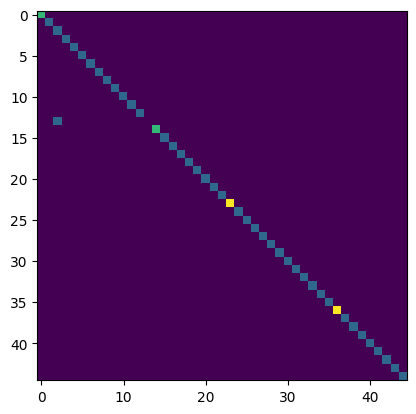

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_right_test_pred = [np.argmax(v) for v in right_eye_model.predict(np.array(X_right_test))]  # Prédictions du modèle


# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(np.array(y_right_test), np.array(y_right_test_pred))

# # Calcul des mesures de performance
accuracy = accuracy_score(y_right_test, y_right_test_pred)
precision = precision_score(y_right_test, y_right_test_pred,average='macro')
recall = recall_score(y_right_test, y_right_test_pred,average='macro')
f1 = f1_score(y_right_test, y_right_test_pred,average='macro')

print("Matrice de confusion :")
plt.imshow(conf_matrix)
print(conf_matrix)
print("Précision : {:.2f}".format(precision))
print("Rappel : {:.2f}".format(recall))
print("Score F1 : {:.2f}".format(f1))
print("Exactitude : {:.2f}".format(accuracy))


Mise en du Modèle pour déterminer la nature de l'oeil

In [8]:
# Etiquetage


# Créez des listes pour les données des yeux gauches et droits
X_left = []
X_right = []
y_left = []
y_right = []

for target_folder in os.listdir(main_folder):
    target_path = os.path.join(main_folder, target_folder)

    if os.path.isdir(target_path):
        for side in ['left', 'right']:
            side_path = os.path.join(target_path, side)
            if os.path.isdir(side_path):
                for image_filename in os.listdir(side_path):
                    if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
                        image_path = os.path.join(side_path, image_filename)
                        target = int(target_folder)
                        image = preprocess_img(cv2.imread(image_path), img_dim)

                        if side == 'left':
                            X_left.append(image)
                            y_left.append(0)  # Étiquette pour œil gauche
                        else:
                            X_right.append(image)
                            y_right.append(1)  # Étiquette pour œil droit


In [32]:
from sklearn.model_selection import train_test_split

# Divisez les données d'œil gauche en ensembles de train, val et test
X_train_left, X_temp_left, y_train_left, y_temp_left = train_test_split(X_left, y_left, test_size=0.2, random_state=42)
X_val_left, X_test_left, y_val_left, y_test_left = train_test_split(X_temp_left, y_temp_left, test_size=0.5, random_state=42)

# Divisez les données d'œil droit en ensembles de train, val et test
X_train_right, X_temp_right, y_train_right, y_temp_right = train_test_split(X_right, y_right, test_size=0.2, random_state=42)
X_val_right, X_test_right, y_val_right, y_test_right = train_test_split(X_temp_right, y_temp_right, test_size=0.5, random_state=42)

# Fusionnez les ensembles d'œil gauche et d'œil droit correspondants pour obtenir les ensembles finaux
X_train = X_train_left + X_train_right
X_val = X_val_left + X_val_right
X_test = X_test_left + X_test_right
y_train = y_train_left + y_train_right
y_val = y_val_left + y_val_right
y_test = y_test_left + y_test_right


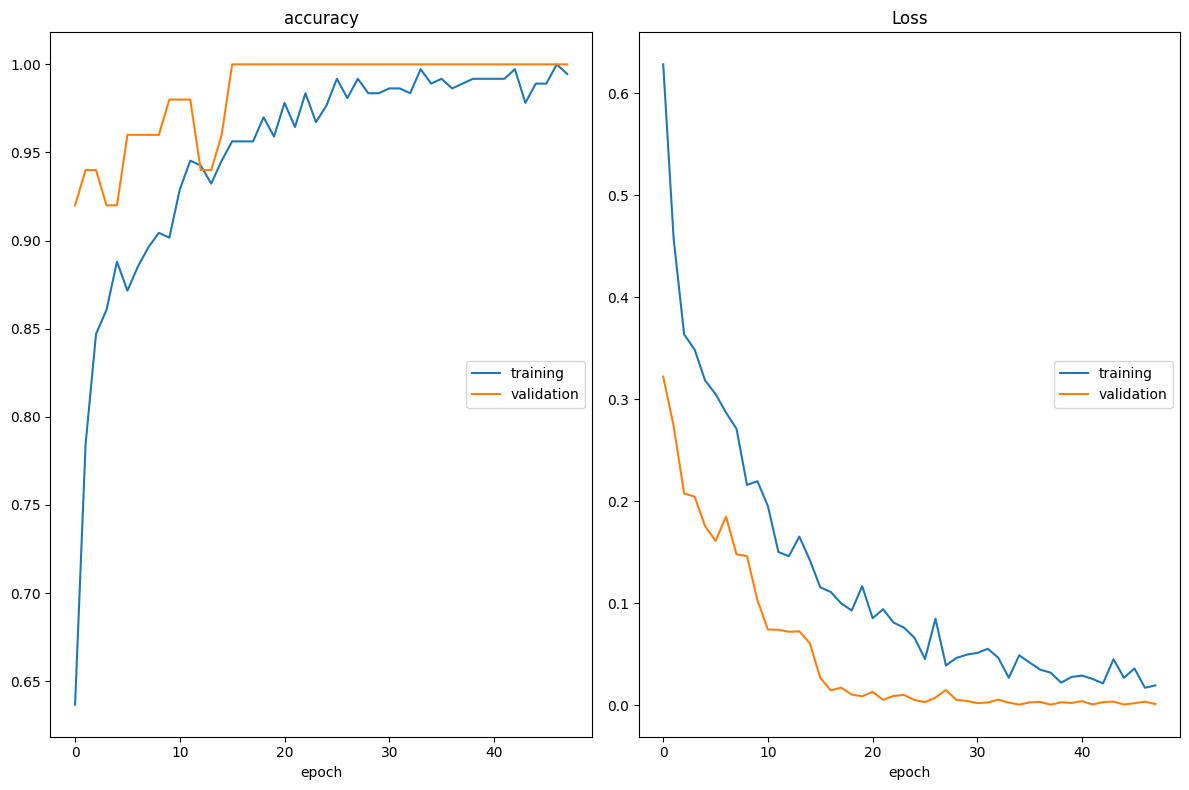

accuracy
	training         	 (min:    0.637, max:    1.000, cur:    0.995)
	validation       	 (min:    0.920, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.017, max:    0.628, cur:    0.019)
	validation       	 (min:    0.001, max:    0.322, cur:    0.001)
12/12 [==============================] - 7s 614ms/step - loss: 0.0195 - accuracy: 0.9945 - val_loss: 0.0012 - val_accuracy: 1.0000


In [38]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras
import numpy as np
from keras.callbacks import EarlyStopping

# Création d'un modèle séquentiel
OD_OG_Model = Sequential()

# Couches de convolution et de max pooling
OD_OG_Model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(240, 320, 3)))
OD_OG_Model.add(MaxPooling2D((2, 2)))
OD_OG_Model.add(Conv2D(64, (3, 3), activation='relu'))
OD_OG_Model.add(MaxPooling2D((2, 2)))
OD_OG_Model.add(Conv2D(128, (3, 3), activation='relu'))
OD_OG_Model.add(MaxPooling2D((2, 2)))

# Couches totalement connectées
OD_OG_Model.add(Flatten())
OD_OG_Model.add(Dense(128, activation='relu'))
OD_OG_Model.add(Dropout(0.5))
OD_OG_Model.add(Dense(1, activation='sigmoid'))  # Utiliser sigmoid pour la classification binaire

# Compilation du modèle
optimizer = Adam(lr=0.0001)
OD_OG_Model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Génération de données avec des augmentations légères
datagen = ImageDataGenerator(
    brightness_range=(0.95, 1),
    zoom_range=(0.95, 1),
    rotation_range=10,
    width_shift_range=0.1,
    #height_shift_range=0.1,
    #horizontal_flip=True
)


X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

datagen.fit(X_train)

# Créez un callback pour l'arrêt précoce
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraînement du modèle avec l'arrêt précoce
history = OD_OG_Model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) // 32,
                    epochs=110,  # Augmentez le nombre d'époques
                    validation_data=(X_val, y_val),  # Utilisez directement les ensembles de validation que vous avez créés
                    callbacks=[PlotLossesKeras(), early_stopping])


In [40]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Obtenir les prédictions du modèle sur l'ensemble de test
y_pred = OD_OG_Model.predict(np.array(X_test))
y_pred = (y_pred > 0.5)  # Appliquer un seuil de décision (0.5 dans ce cas)

# Calculer la matrice de confusion
confusion = confusion_matrix(y_test, y_pred)

# Calculer la précision (accuracy)
accuracy = accuracy_score(y_test, y_pred)

# Afficher la matrice de confusion et la précision
print("Matrice de Confusion :")
print(confusion)
print("\nPrécision (Accuracy) : {:.2f}%".format(accuracy * 100))

# Afficher un rapport de classification
report = classification_report(y_test, y_pred, target_names=['Œil Gauche', 'Œil Droit'])
print("\nRapport de Classification :")
print(report)


2/2 [==============================] - 1s 743ms/step
Matrice de Confusion :
[[25  0]
 [ 0 26]]

Précision (Accuracy) : 100.00%

Rapport de Classification :
              precision    recall  f1-score   support

  Œil Gauche       1.00      1.00      1.00        25
   Œil Droit       1.00      1.00      1.00        26

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



In [41]:
OD_OG_Model.save('/home/diaby/IA_EXOS/CAS_PRATIQUES/OD_OG_Model.h5')